In this notebook we show how we can synthesize dimensionality reduction models across subjects when we record data from different conditions from each of those subjects.  We demonstrate that we can reliably see how the latent variables for each condition are located with respect to one another in a low-d space, even though the data for each condition comes from a different subject.  We first associate 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
from pathlib import Path

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import ot
import scipy.io
import sklearn.decomposition as decomposition
import sklearn.discriminant_analysis as discriminant_analysis
import torch

from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.image_generation import generate_dot_image_3d
from janelia_core.visualization.custom_color_maps import make_purple_green_c_map
from janelia_core.visualization.volume_visualization import signed_max_proj
from janelia_core.visualization.volume_visualization import visualize_projs
from probabilistic_model_synthesis.data_utils import read_in_ahrens_data_for_dim_reduction
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import synthesize_fa_mdls
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection


/groups/bishop/bishoplab/projects/janelia_core/janelia_core/visualization/volume_visualization.py:22: UserWarning: Unable to import moviepy.  Minor functionality will not be available.
  warnings.warn('Unable to import moviepy.  Minor functionality will not be available.')


In [3]:
%matplotlib notebook
plt.style.use("dark_background")

## Parameters go here

In [4]:
ps = dict()

# Specify the directory where all the raw data is found
ps['data_dir'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data'

# Here we list the subject we want to fit and the conditions we want to fit on for each subject when we observe data
# from different conditions for different subjects
ps['diff_cond_fit_specs'] = {8: ['omr_forward'], 
                             9: ['omr_left'], 
                            11: ['omr_right']} 

# Here we list the subject we want to fit and the conditions we want to fit on for each subject when we observe data
# for the same conditions for each subject - we use this data for fitting baseline FA models to
ps['same_cond_fit_specs'] = {8: ['omr_forward', 'omr_left', 'omr_right'], 
                            9: ['omr_forward', 'omr_left', 'omr_right'], 
                            11: ['omr_forward', 'omr_left', 'omr_right']} 
    
# Options for preprocessing the data
preprocess_opts = {'neural_gain': 10}

# Here we specify if we fit in conditions with shock or not
ps['shock'] = False

# Number of inidividual slices of each type of subperiod we use for validation
ps['n_validation_slices'] = 2

# Number of latent variables in the model
ps['n_latent_vars'] = 10

# Options for setting up priors when synthesizing models
ps['prior_opts'] = {'hc_params': {'n_divisions_per_dim': [50, 30, 17], 
                                  'dim_ranges': np.asarray([[0, 990.0], [0, 610.0], [0, 350.0]]),
                                  'n_div_per_hc_side_per_dim': [1, 1, 1]},
                    's_mn': 1.0,  # Mean for the prior on scales
                    's_std': .0001  # Standard deviation for the prior on scales
                   }

# Options for setting up the posteriors when synthesizing models
ps['post_opts'] = {'s_opts': {'mn_mn': 1.0, 
                              'mn_std': .00000001, 
                              'std_lb': .00001, 
                              'std_iv': .0001}}

# Provide a folder to save check points into
ps['cp_save_folder'] = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/glndr_testing/across_cond_cps'

# Fitting options
ps['sp_fit_opts'] = [{'n_epochs': 1000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]
ps['ip_fit_opts'] = [{'n_epochs': 200, 'milestones': [500, 700], 'update_int': 100, 'init_lr': .001, 
                      'cp_save_folder': ps['cp_save_folder'], 'cp_epochs': np.arange(0, 200, 10)}]

# Location to anatomical stack
ps['anat_file'] = r'/groups/bishop/bishoplab/projects/ahrens_wbo/data/ReferenceBrain.mat'


## Load the data 

In [8]:
# Read in data when we observe data from different conditions for different individuals - here we set aside some
# data for validation data, that we will use for early stopping
diff_cond_data, diff_cond_label_map, neuron_locs = read_in_ahrens_data_for_dim_reduction(data_dir = ps['data_dir'], 
                                                                            fit_specs=ps['diff_cond_fit_specs'],
                                                                            shock=ps['shock'], 
                                                        n_validation_slices=ps['n_validation_slices'],
                                                                            preprocess_opts=preprocess_opts)

# Read in data when we observe data for the same conditions for each individual - we don't need validation data
# here since we just fit these models with standard FA models 
same_cond_data, same_cond_label_map, _ = read_in_ahrens_data_for_dim_reduction(data_dir = ps['data_dir'], 
                                                                            fit_specs=ps['same_cond_fit_specs'],
                                                                            shock=ps['shock'], 
                                                                            n_validation_slices=0,
                                                                            preprocess_opts=preprocess_opts)

Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.
Done loading data for subject subject_8.
Done loading data for subject subject_9.
Done loading data for subject subject_11.


## Fit FA models individually to each subject when we observe the same conditions across all subjects and infer latents

In [9]:
subjects = list(same_cond_data['fit_data'].keys())

Here we fit the models

In [10]:
ind_fa_mdls = {}
for s_n in subjects:
    fa_mdl = decomposition.FactorAnalysis(n_components=ps['n_latent_vars'])
    fa_mdl.fit(same_cond_data['fit_data'][s_n])
    ind_fa_mdls[s_n] = fa_mdl
    print('Done fitting FA model to subject ' + str(s_n) + ' individually.')

Done fitting FA model to subject 8 individually.
Done fitting FA model to subject 9 individually.
Done fitting FA model to subject 11 individually.


Now we infer latents and orthonormalize each model

In [11]:
ind_latents = dict()
for s_n in subjects:
    mdl_n = ind_fa_mdls[s_n]
    latents = mdl_n.transform(same_cond_data['fit_data'][s_n])
    lm_o, latents_o = orthonormalize(mdl_n.components_.transpose(), latents)
    
    ind_latents[s_n] = {'latents': latents, 'latents_o': latents_o, 'lm_o': lm_o}

## Synthesize FA models when we observe data from a different condition in each subject

Here we fit the models

In [12]:
syn_rs = synthesize_fa_mdls(data=[torch.tensor(diff_cond_data['fit_data'][s_n]) for s_n in subjects],
                   props=[neuron_locs[s_n] for s_n in subjects], 
                   n_latent_vars=ps['n_latent_vars'],
                   prior_opts=ps['prior_opts'], 
                   post_opts=ps['post_opts'], 
                   sp_fit_opts=ps['sp_fit_opts'], 
                   ip_fit_opts=ps['ip_fit_opts'])

Found 1 GPUs

=========== EPOCH 0 COMPLETE ===========
Obj: 6.28e+10
----------------------------------------
NELL: 9.57e+07, 2.19e+07, 2.78e+07
Latent KL: 2.42e+02, 6.84e+01, 6.51e+01
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 1.72e+04, 1.87e+04, 2.37e+04
S KL: 1.73e+10, 1.99e+10, 2.54e+10
----------------------------------------
LR: 0.1
Elapsed time (secs): 21.045004844665527
----------------------------------------
CPU cur memory used (GB): 4.42e+00
GPU_0 cur memory used (GB): 2.34e-01, max memory used (GB): 2.34e-01

=========== EPOCH 100 COMPLETE ===========
Obj: 6.29e+07
----------------------------------------
NELL: 4.13e+07, 9.97e+06, 1.14e+07
Latent KL: 1.39e+04, 3.43e+03, 3.17e+03
LM KL: 0.00e+00, 0.00e+00, 0.00e+00
Mn KL: 0.00e+00, 0.00e+00, 0.00e+00
Psi KL: 6.61e+04, 6.82e+04, 7.62e+04
S KL: 3.66e+01, 1.31e+01, 1.90e+01
----------------------------------------
LR: 0.1
Elapsed time (secs): 53.622889280319214
------------------------------

Here we perform (retrospective) early stopping using validation data

In [13]:
devices, _ = list_torch_devices()

Found 1 GPUs


In [14]:
cp_epochs, cp_elbo = evaluate_check_points(cp_folder=ps['cp_save_folder'], 
                              data=[torch.tensor(diff_cond_data['validation_data'][s_n]) for s_n in subjects], 
                              props=[neuron_locs[s_n] for s_n in subjects], 
                              n_smps=100, device=devices[0])

Done with check point: 1 of 20.
Done with check point: 2 of 20.
Done with check point: 3 of 20.
Done with check point: 4 of 20.
Done with check point: 5 of 20.
Done with check point: 6 of 20.
Done with check point: 7 of 20.
Done with check point: 8 of 20.
Done with check point: 9 of 20.
Done with check point: 10 of 20.
Done with check point: 11 of 20.
Done with check point: 12 of 20.
Done with check point: 13 of 20.
Done with check point: 14 of 20.
Done with check point: 15 of 20.
Done with check point: 16 of 20.
Done with check point: 17 of 20.
Done with check point: 18 of 20.
Done with check point: 19 of 20.
Done with check point: 20 of 20.


In [15]:
best_cp_epoch = cp_epochs[np.argmax(np.mean(cp_elbo, axis=1))].astype('int')
print('Best epoch is ' + str(best_cp_epoch) + '.')

best_cp = torch.load(Path(ps['cp_save_folder']) / ('cp_' + str(best_cp_epoch) + '.pt'))    
eval_vi_collections = [VICollection.from_checkpoint(coll_d) for coll_d in best_cp['vi_collections']]
for c_i, coll in enumerate(eval_vi_collections):
    coll.props = syn_rs['ip']['vi_collections'][c_i].props
eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
eval_posteriors = [coll.posteriors for coll in eval_vi_collections]  


Best epoch is 30.


Here we infer latents using the best model (picked with early stopping) using all data and orthonormalize each model

In [16]:
full_diff_data = {s_n: np.concatenate([diff_cond_data['fit_data'][s_n], 
                                       diff_cond_data['validation_data'][s_n]], axis=0)
                  for s_n in subjects}

full_diff_labels = {s_n: np.concatenate([diff_cond_data['fit_labels'][s_n], 
                                         diff_cond_data['validation_labels'][s_n]], axis=0)
                    for s_n in subjects}

In [17]:
syn_latent_posts ={s_n: infer_latents(n_latent_vars=ps['n_latent_vars'],
                                      vi_collection=eval_vi_collections[s_i],
                                      data=torch.tensor(full_diff_data[s_n]),
                                      fit_opts={'n_epochs': 1000, 'init_lr':.1, 'update_int':None, 
                                                'milestones': [500]}, 
                                      device=devices[0])[0]
                    for s_i, s_n in enumerate(subjects)}

In [18]:
# We orthonormalize based on the a loading matrix formed for neurons across all fish
syn_lm_conc = torch.cat([eval_posteriors[s_i].lm_post(neuron_locs[s_n]) for s_i, s_n in enumerate(subjects)],
                         dim=0).detach().numpy()

syn_latents = dict()
for s_n in subjects:
    latents = syn_latent_posts[s_n].mns.detach().numpy()
    _, latents_o = orthonormalize(syn_lm_conc, latents)
    syn_latents[s_n] = {'latents': latents, 'latents_o': latents_o}

## Get things in place for plotting

In [19]:
n_subperiods = len(same_cond_label_map)
subperiod_clrs = {k: cm.Set1(k_i/(n_subperiods-1)) for k_i, k in enumerate(same_cond_label_map.keys())}
subject_markers = {8: 'o', 9: 'v', 11:'X'}

In [20]:
subperiod_clrs

{'omr_left': (0.8941176470588236,
  0.10196078431372549,
  0.10980392156862745,
  1.0),
 'omr_forward': (1.0, 0.4980392156862745, 0.0, 1.0),
 'omr_right': (0.6, 0.6, 0.6, 1.0)}

## View low-d projection of data when we observe the same conditions in all subjects. 

This is to provide a baseline to see how the low-d projections of data look when we have the ability to record data
for all subjects in each subject

<IPython.core.display.Javascript object>


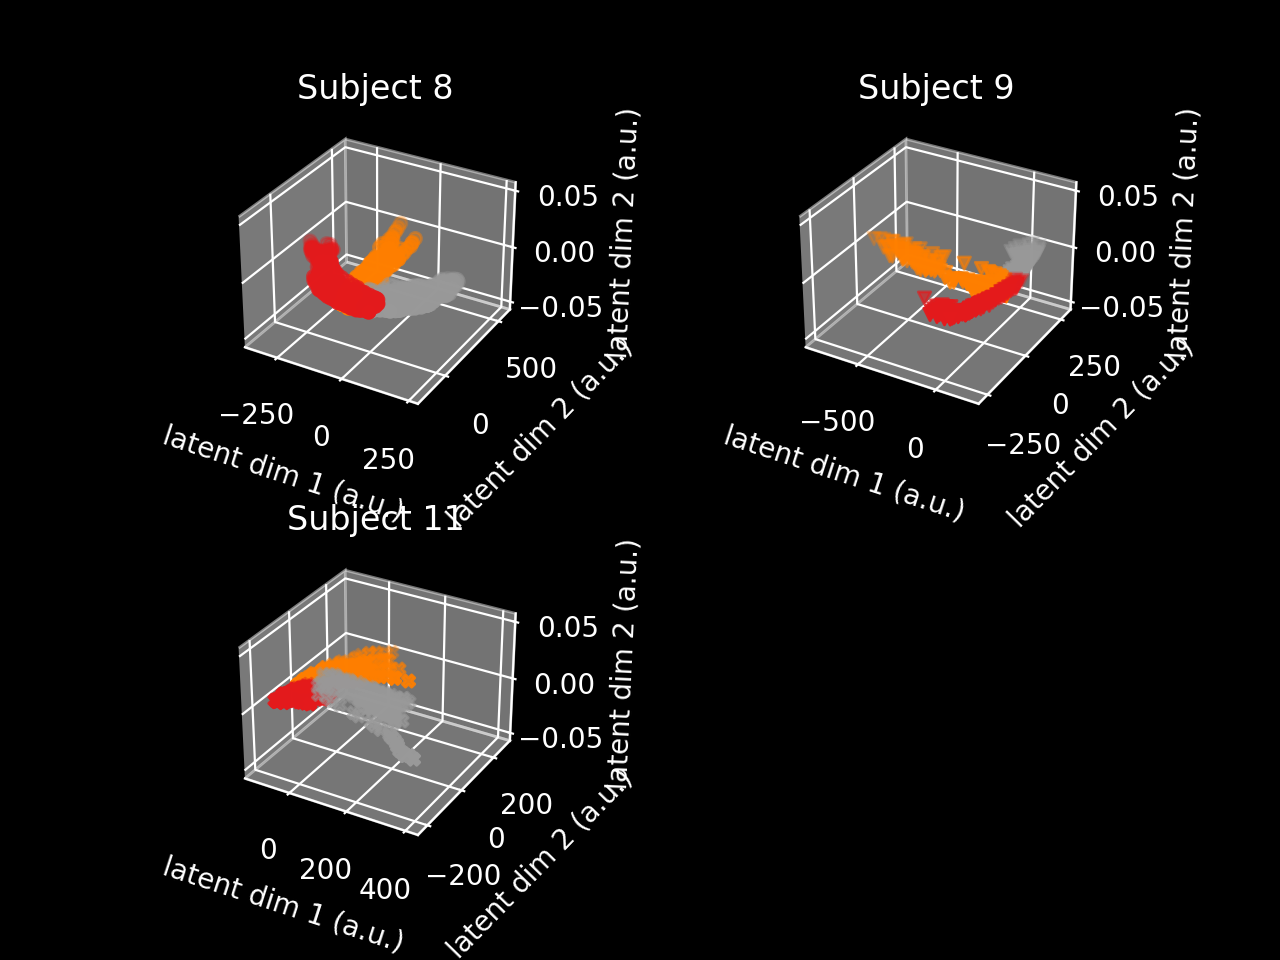

In [22]:
plt.figure()
for s_i, s_n in enumerate(subjects):
    ax = plt.subplot(2,2, s_i+1, projection='3d')
    plt.title('Subject ' + str(s_n))
    
    plot_latents = ind_latents[s_n]['latents_o']
    plot_labels = same_cond_data['fit_labels'][s_n]
    
    lda_mdl = discriminant_analysis.LinearDiscriminantAnalysis()
    lda_mdl.fit(plot_latents, plot_labels)
    plot_projs = lda_mdl.transform(plot_latents)
    plot_projs = plot_latents[:,0:3]
    
    for sp, sp_lbl in same_cond_label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_projs[sp_inds,0], plot_projs[sp_inds,1], color=sp_clr, marker=subject_markers[s_n])
        plt.xlabel('latent dim 1 (a.u.)')
        plt.ylabel('latent dim 2 (a.u.)')
        ax.set_zlabel('latent dim 2 (a.u.)')
    
plt.subplots_adjust(wspace=.3, hspace=.4)

## View low-d projection of data when we observe the different conditions in all subjects. 

Here we find a good projection that seprates the different classes in the low-d space

In [23]:
syn_latents_o_conc = np.concatenate([syn_latents[s_n]['latents_o'] for s_n in subjects], axis=0)
syn_labels_o_conc = np.concatenate([full_diff_labels[s_n] for s_n in subjects], axis=0)
syn_lda_mdl = discriminant_analysis.LinearDiscriminantAnalysis()
syn_lda_mdl.fit(syn_latents_o_conc, syn_labels_o_conc)

LinearDiscriminantAnalysis()

<IPython.core.display.Javascript object>


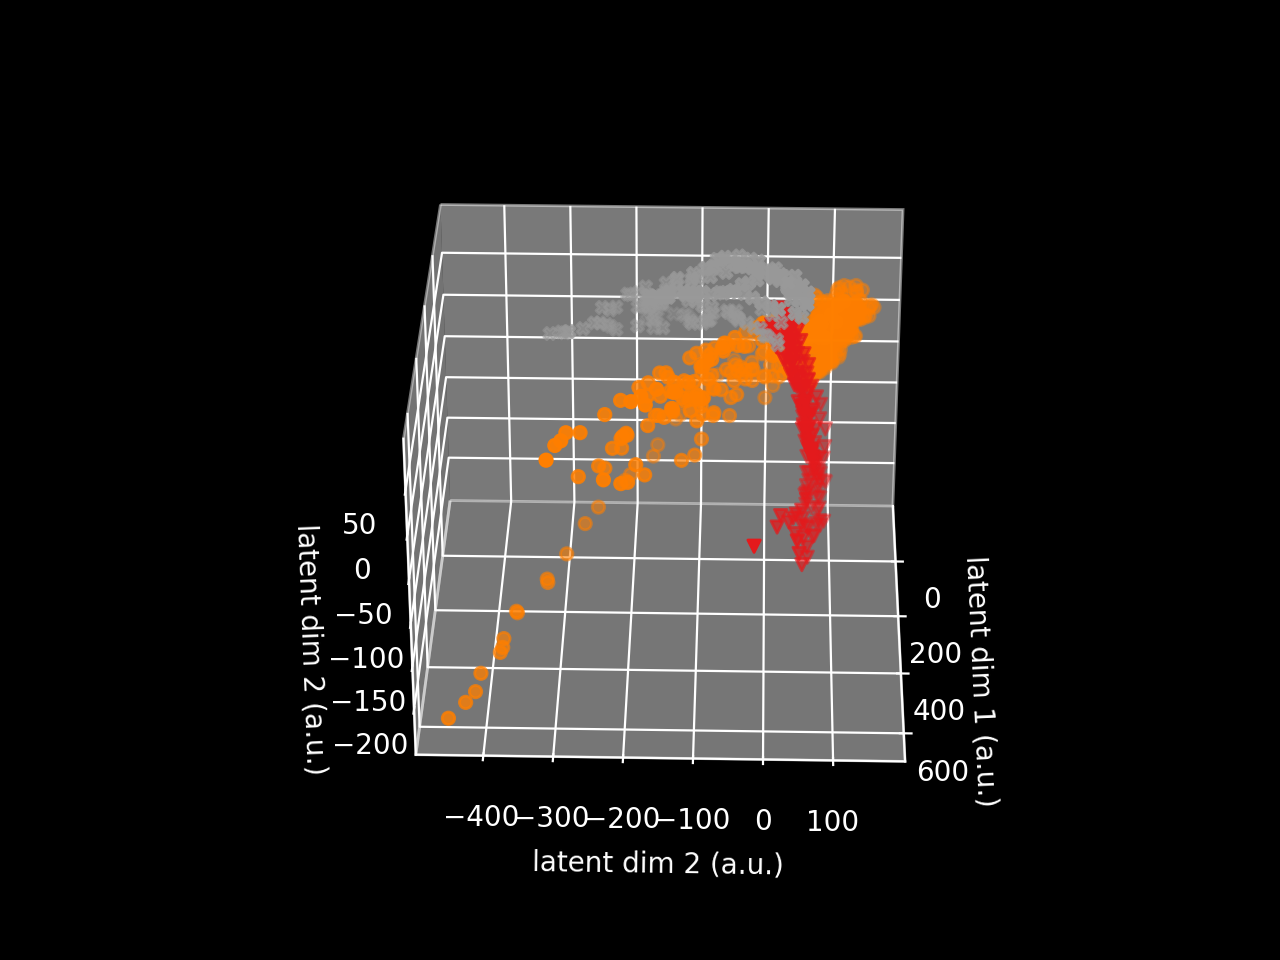

In [24]:
plt.figure()
ax = plt.subplot(1,1, 1, projection='3d')
for s_i, s_n in enumerate(subjects):
        
    plot_latents = syn_latents[s_n]['latents_o']
    plot_labels = full_diff_labels[s_n]
    
    plot_projs = syn_lda_mdl.transform(plot_latents)
    plot_projs = plot_latents[:, 0:3]
    
    for sp, sp_lbl in same_cond_label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_projs[sp_inds,0], plot_projs[sp_inds,1], plot_projs[sp_inds,2], color=sp_clr, marker=subject_markers[s_n])
        plt.xlabel('latent dim 1 (a.u.)')
        plt.ylabel('latent dim 2 (a.u.)')
        ax.set_zlabel('latent dim 2 (a.u.)')
    
plt.subplots_adjust(wspace=.3, hspace=.3)

## Generate images of modes across fish

In [25]:
vis_modes = [0, 1, 2] # list of orthonormalized modes to visualize

In [26]:
syn_lm_conc_o, _ = orthonormalize(syn_lm_conc)
sym_lm_o = dict()

cur_start = 0
for s_n in subjects:
    n_vars_n = diff_cond_data['fit_data'][s_n].shape[1]
    # Signle orthonormalization across all fish
    sym_lm_o[s_n] = syn_lm_conc_o[cur_start:cur_start+n_vars_n]
    # Individual orthonormalization of models
    #sym_lm_o[s_n], _ = orthonormalize(eval_posteriors[s_i].lm_post(neuron_locs[s_n]).detach().numpy())
    cur_start += n_vars_n

In [27]:
mode_imgs = dict()
for s_n in subjects:
    mode_imgs_n = dict()
    for m_i in vis_modes:
        dot_ctrs = copy.deepcopy(neuron_locs[s_n].numpy())
        dot_ctrs[:,2] = dot_ctrs[:,2]/2.5
        mode_imgs_n[m_i] = generate_dot_image_3d(image_shape=[990, 610, 138],
                                                 dot_ctrs=dot_ctrs,
                                                 dot_vls=sym_lm_o[s_n][:,m_i],
                                                  ellipse_shape=[5,5,5])
        
    mode_imgs[s_n] = mode_imgs_n
    print('Done making mode images for subject ' + str(s_n) + '.')


Done making mode images for subject 8.
Done making mode images for subject 9.
Done making mode images for subject 11.


## Load and prepare the image of the raw volume

In [28]:
ref_brain = scipy.io.loadmat(ps['anat_file'])
ref_brain = ref_brain['anat_stack_norm']
ref_brain = ref_brain/np.max(ref_brain)

In [29]:
rb_horz = signed_max_proj(ref_brain,2)
rb_sag = signed_max_proj(ref_brain,1)
rb_cor = np.fliplr(signed_max_proj(ref_brain,0))

## Visualize images of modes

In [30]:
vis_mode = 2

<IPython.core.display.Javascript object>


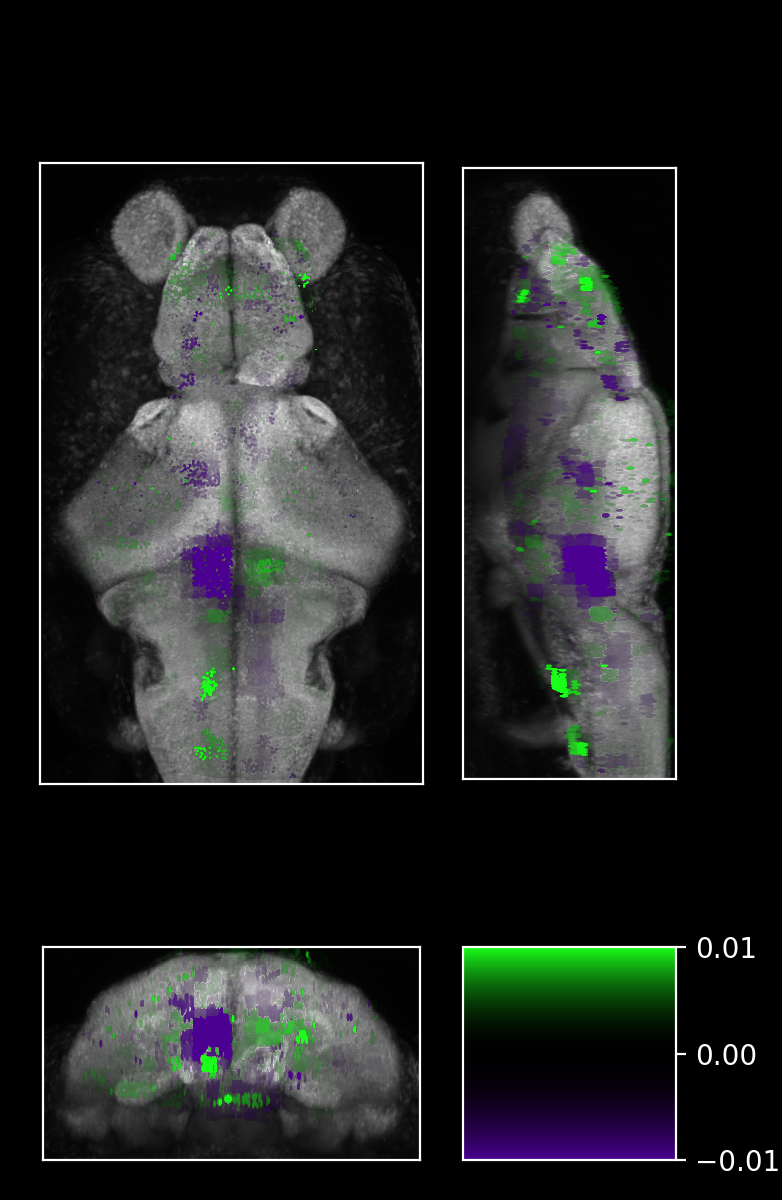

<IPython.core.display.Javascript object>


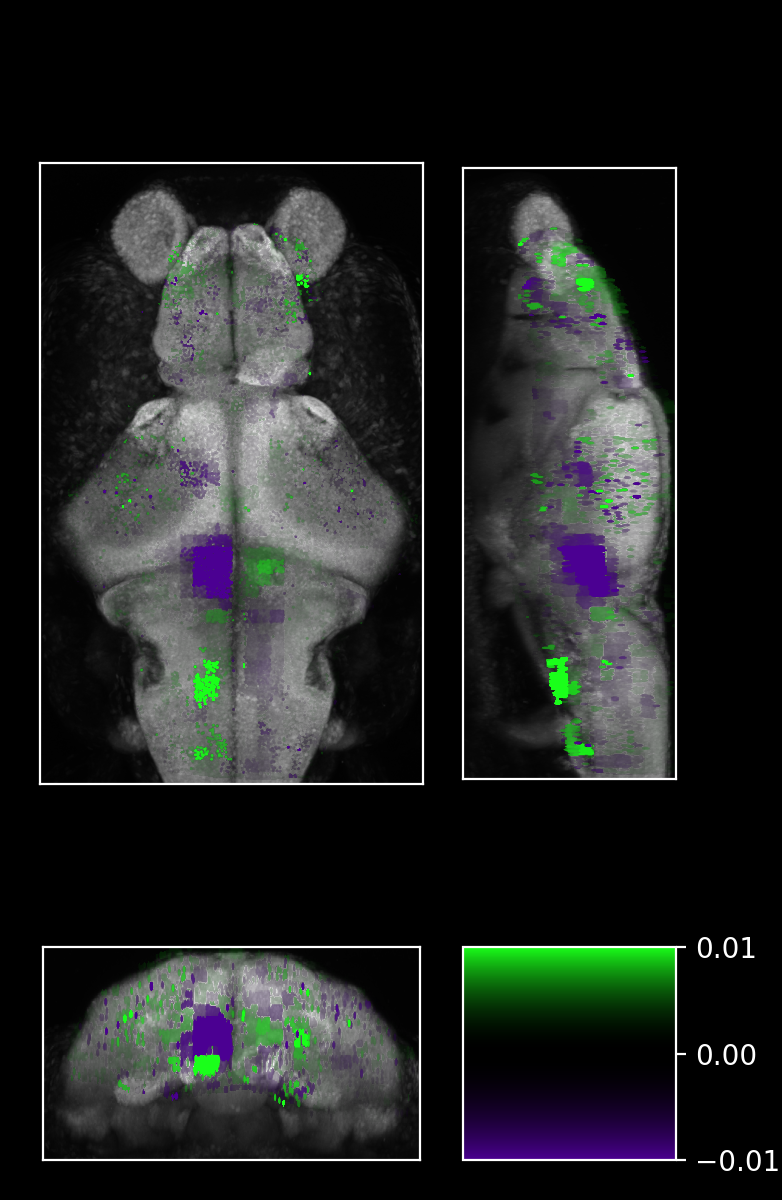

<IPython.core.display.Javascript object>


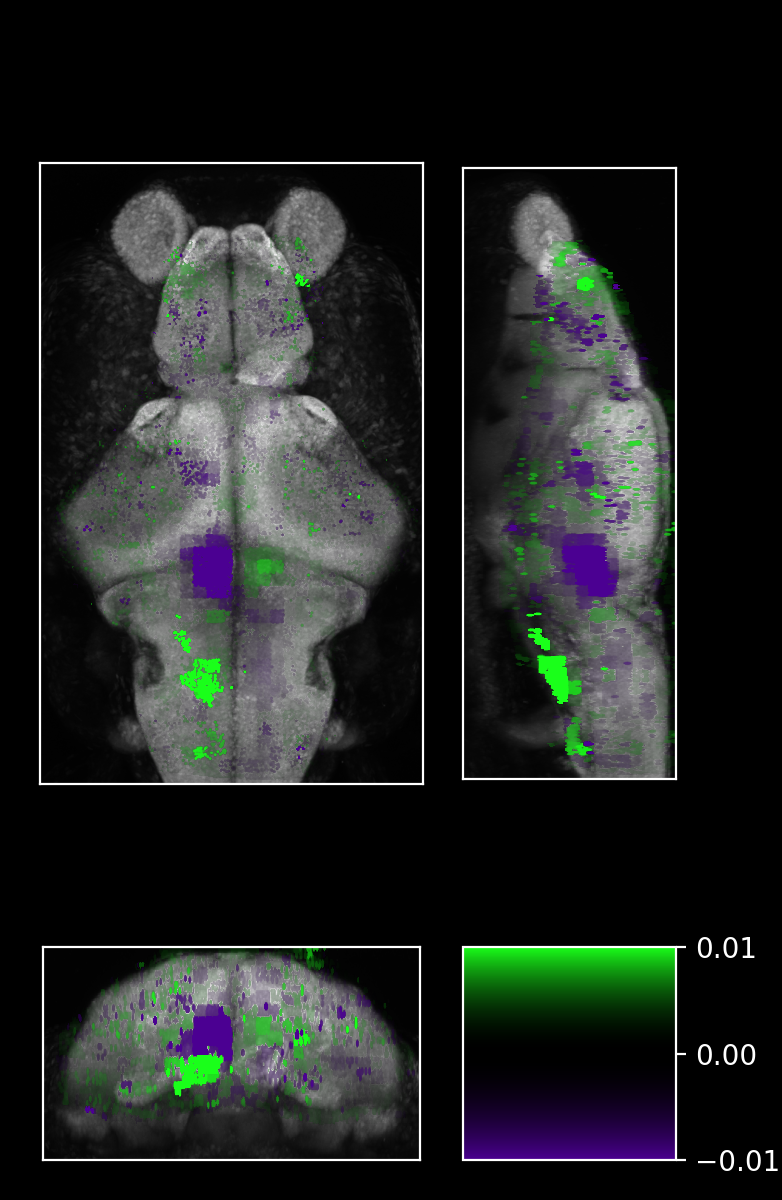

In [31]:
cmap = make_purple_green_c_map(1000, True)

# Visualize a volume
for s_n in subjects:
    vol = mode_imgs[s_n][vis_mode]
    visualize_projs(horz_projs=[rb_horz, signed_max_proj(vol,2)],
                    sag_projs=[rb_sag, signed_max_proj(vol,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(vol,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], [-.01, .01]], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,2.5])

## Now we fit FA models when we observe fish under different conditions

In [32]:
diff_ind_fa_mdls = {}
for s_n in subjects:
    fa_mdl = decomposition.FactorAnalysis(n_components=ps['n_latent_vars'])
    fa_mdl.fit(diff_cond_data['fit_data'][s_n])
    diff_ind_fa_mdls[s_n] = fa_mdl
    print('Done fitting FA model to subject ' + str(s_n) + ' individually.')

Done fitting FA model to subject 8 individually.
Done fitting FA model to subject 9 individually.
Done fitting FA model to subject 11 individually.


Here we orthonormalize the loading matrices of the modesls

In [33]:
diff_ind_latents = dict()
for s_n in subjects:
    mdl_n = diff_ind_fa_mdls[s_n]
    latents = mdl_n.transform(diff_cond_data['fit_data'][s_n])
    lm_o, latents_o = orthonormalize(mdl_n.components_.transpose(), latents)
    
    diff_ind_latents[s_n] = {'latents': latents, 'latents_o': latents_o, 'lm_o': lm_o}

Align the different orthonormalized latents with optimal transport

In [34]:
tgt_subject = subjects[0]
tgt_latents = diff_ind_latents[tgt_subject]['latents_o']
diff_ind_latents[tgt_subject]['latents_ot'] = tgt_latents
for s_n in subjects[1:]:
    a_ot, b_ot = ot.da.OT_mapping_linear(diff_ind_latents[s_n]['latents_o'], tgt_latents)
    diff_ind_latents[s_n]['latents_ot'] = diff_ind_latents[s_n]['latents_o'].dot(a_ot) + b_ot

## Visualized the latents from models fit individually to data from different conditions and then the distributions of latents are aligned

In [35]:
diff_ind_latents_o_conc = np.concatenate([diff_ind_latents[s_n]['latents_ot'] for s_n in subjects], axis=0)
diff_ind_labels_o_conc = np.concatenate([diff_cond_data['fit_labels'][s_n] for s_n in subjects], axis=0)
diff_ind_lda_mdl = discriminant_analysis.LinearDiscriminantAnalysis()
diff_ind_lda_mdl.fit(diff_ind_latents_o_conc, diff_ind_labels_o_conc)

LinearDiscriminantAnalysis()

<IPython.core.display.Javascript object>


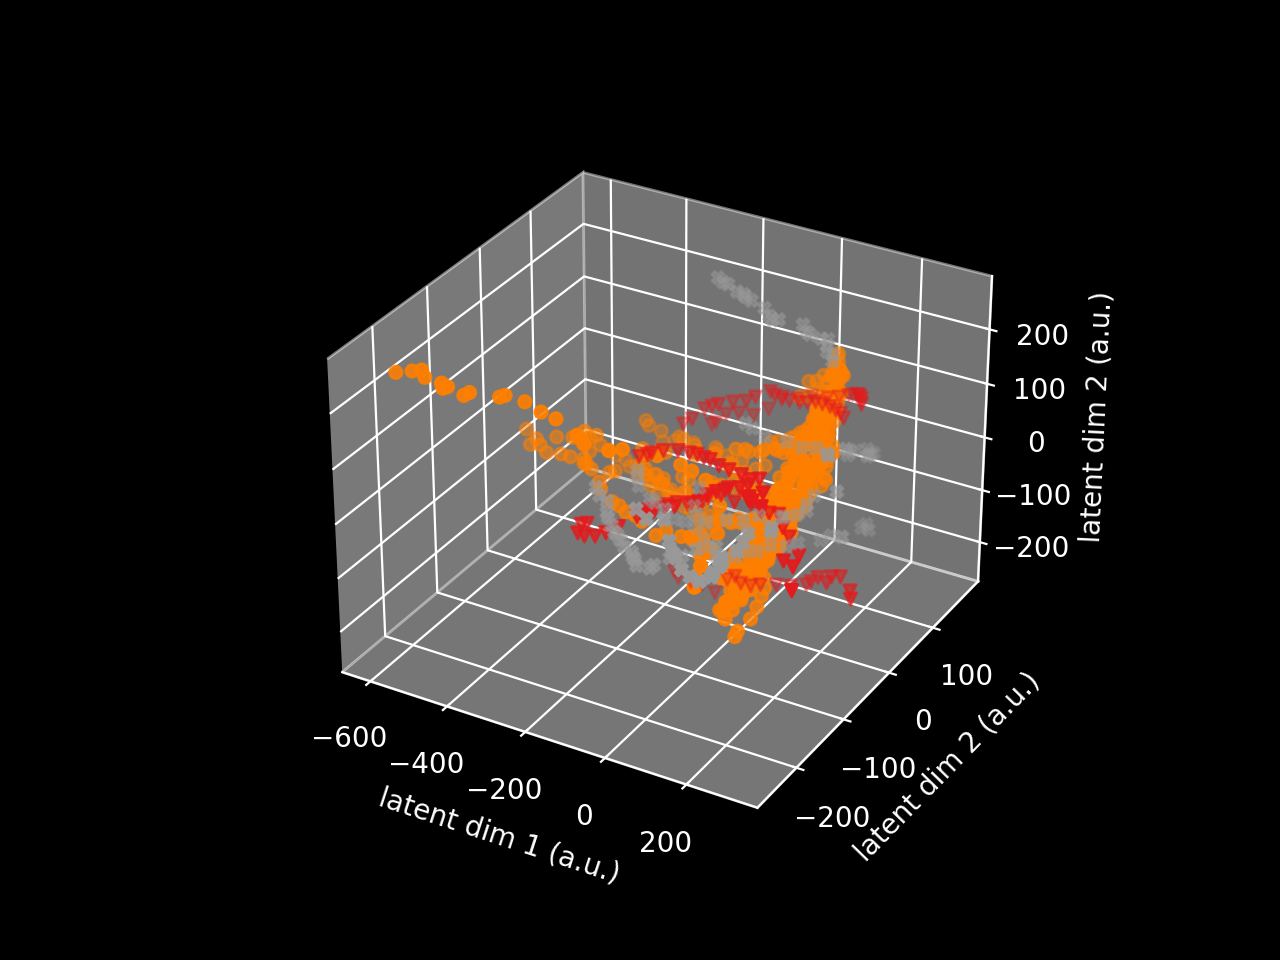

In [36]:
plt.figure()
ax = plt.subplot(1,1, 1, projection='3d')
for s_i, s_n in enumerate(subjects):
        
    plot_latents = diff_ind_latents[s_n]['latents_o']
    plot_labels = diff_cond_data['fit_labels'][s_n]
    
    plot_projs = diff_ind_lda_mdl.transform(plot_latents)
    plot_projs = plot_latents[:, 0:3]
    
    for sp, sp_lbl in same_cond_label_map.items():
        sp_clr = subperiod_clrs[sp]
        sp_inds = plot_labels == sp_lbl
        ax.scatter(plot_projs[sp_inds,0], plot_projs[sp_inds,1], plot_projs[sp_inds,2],
                   color=sp_clr, marker=subject_markers[s_n])
        plt.xlabel('latent dim 1 (a.u.)')
        plt.ylabel('latent dim 2 (a.u.)')
        ax.set_zlabel('latent dim 2 (a.u.)')
    
plt.subplots_adjust(wspace=.3, hspace=.3)

## Visualize the modes of the different subjects

Here we generate volumes of the orthonormalized modes

In [37]:
diff_ind_mode_imgs = dict()
for s_n in subjects:
    mode_imgs_n = dict()
    for m_i in vis_modes:
        dot_ctrs = copy.deepcopy(neuron_locs[s_n].numpy())
        dot_ctrs[:,2] = dot_ctrs[:,2]/2.5
        mode_imgs_n[m_i] = generate_dot_image_3d(image_shape=[990, 610, 138],
                                                 dot_ctrs=dot_ctrs,
                                                 dot_vls=diff_ind_latents[s_n]['lm_o'][:,m_i],
                                                 ellipse_shape=[5,5,5])
        
    diff_ind_mode_imgs[s_n] = mode_imgs_n
    print('Done making mode images for subject ' + str(s_n) + '.')


Done making mode images for subject 8.
Done making mode images for subject 9.
Done making mode images for subject 11.


Here we visualize the modes of the different subjects

<IPython.core.display.Javascript object>


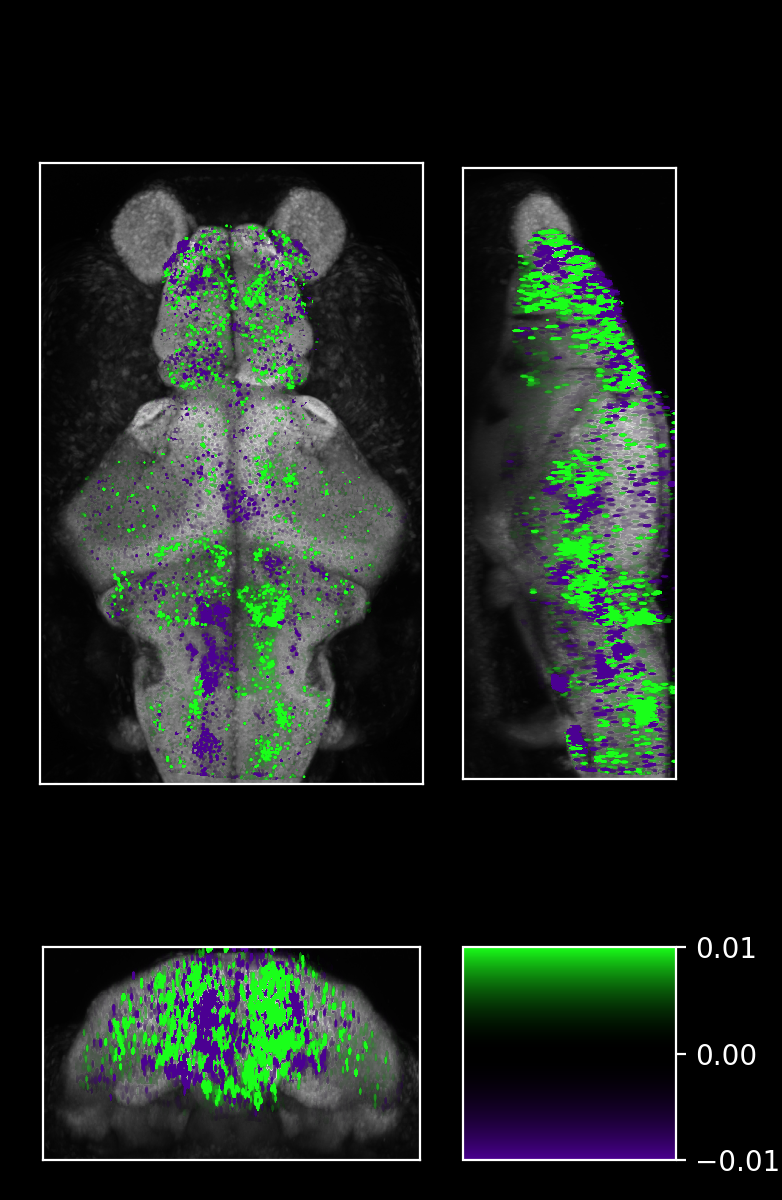

<IPython.core.display.Javascript object>


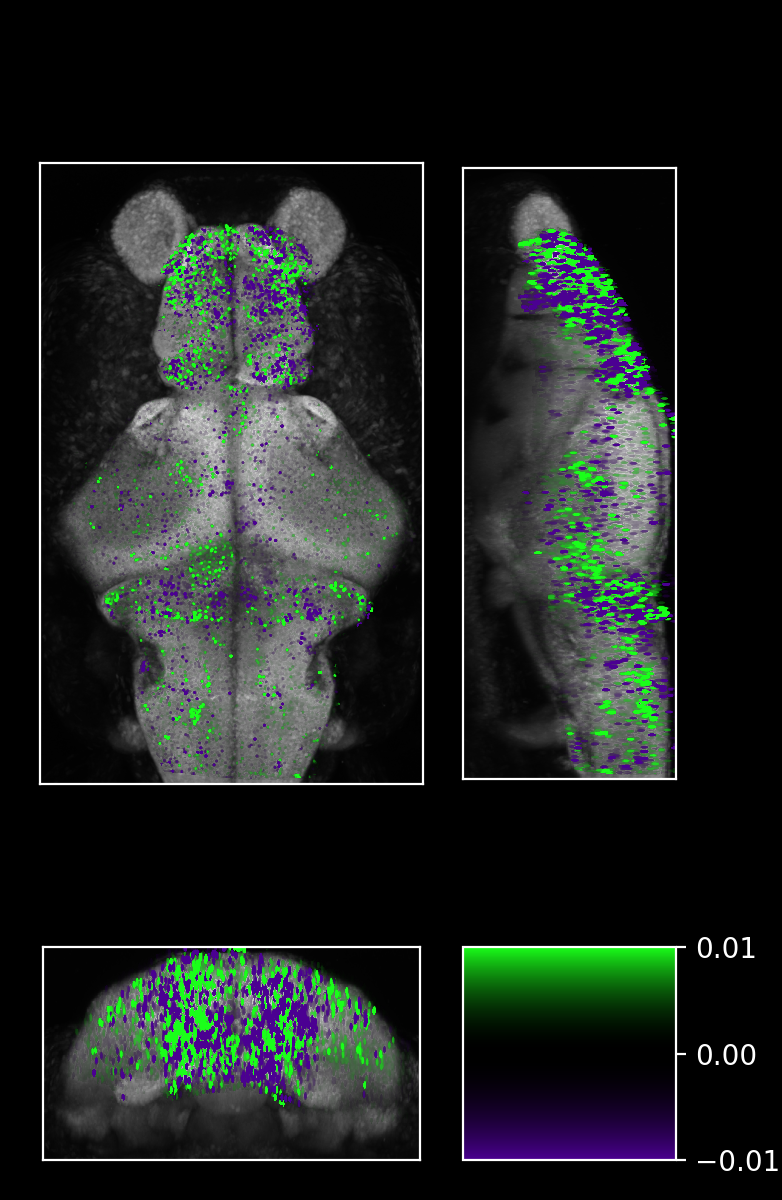

<IPython.core.display.Javascript object>


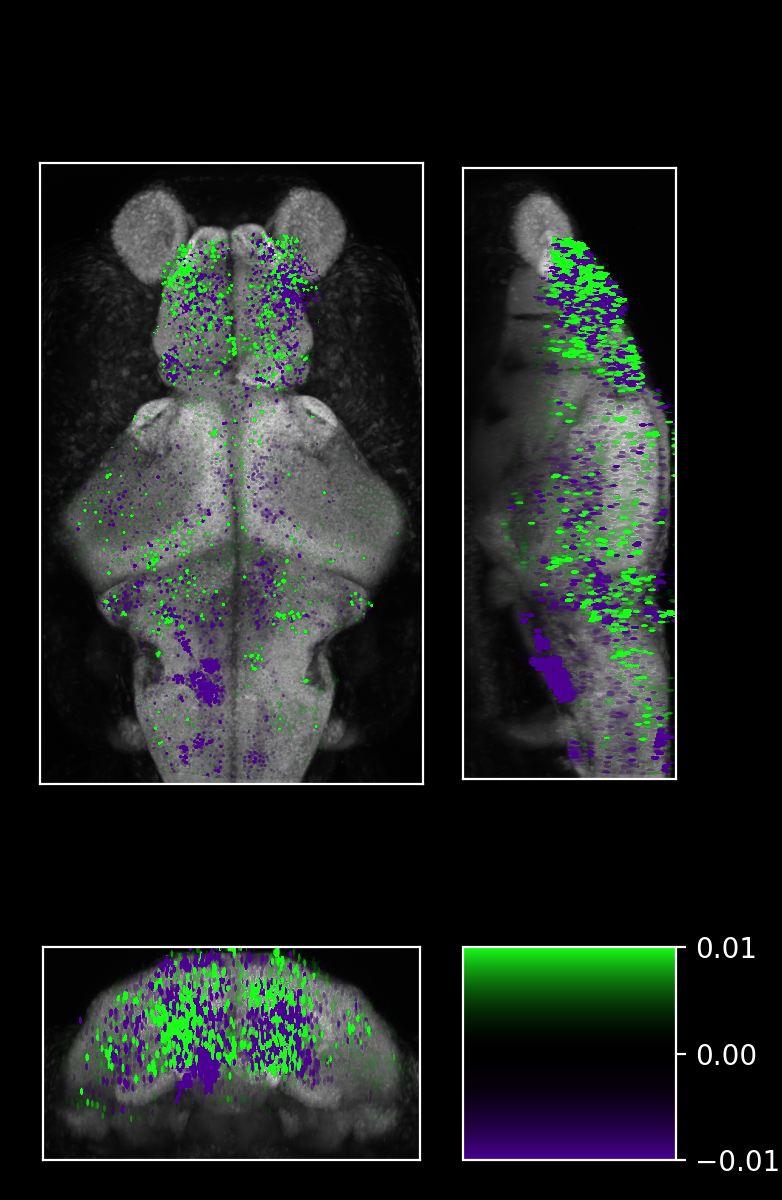

In [38]:
cmap = make_purple_green_c_map(1000, True)

# Visualize a volume
for s_n in subjects:
    vol = diff_ind_mode_imgs[s_n][vis_mode]
    visualize_projs(horz_projs=[rb_horz, signed_max_proj(vol,2)],
                    sag_projs=[rb_sag, signed_max_proj(vol,1)], 
                    cor_projs=[rb_cor, np.fliplr(signed_max_proj(vol,0))], 
                    cmaps=[cm.gray, cmap], 
                    clims=[[0, 1], [-.01, .01]], 
                    plot_cmap=True, 
                    buffer=.1, 
                    dim_m=[1,1,2.5])